In [1]:
from main import main
from PDconfig import LaVoz
from frames.archivosDF import *

main()
ruta_barrios = './DataFrames/LaVoz/barrios.csv'
ruta_ciudades = './DataFrames/LaVoz/ciudades.csv'
df = abrirDF(LaVoz)

In [2]:
# Completar datos:
filt = df["terrenoEdificado"].isna() & df["tipoPropiedad"] == "DEPARTAMENTO"
df.loc[filt, "terrenoEdificado"] = df.loc[filt, "terrenoTotal"]

In [3]:
# FILTRADO DE DATOS GENERAL
df.drop_duplicates(subset='id', keep='last', inplace=True, ignore_index=False)
df = df.dropna(how="all", subset=['terrenoTotal', 'terrenoEdificado', 'cantDormitorios', 'cantBanos', 'cantCochera'])

# CAMBIAR TIPOS PROP
reemplazos = {
  "DUPLEX" : "CASA",
  "DÚPLEX" : "CASA",
  "TRIPLEX" : "CASA",
  "CHALET" : "CASA", 
  "PREFABRICADA": "CASA", 
  "CABAÑA" : "CASA",
  "SEMIPISO" : "DEPARTAMENTO",
  "PISO" : "DEPARTAMENTO",
  "PENTHOUSE" : "DEPARTAMENTO",
  "LOFT" : "DEPARTAMENTO"
}
df["tipoPropiedad"].replace(reemplazos, inplace= True)

# ELIMINAR TIPO PROP INSERVIBLES
filt = (df["tipoPropiedad"] == "CASA") | (df["tipoPropiedad"] == "DEPARTAMENTO") | (df["tipoPropiedad"] == "TERRENOS LOTES")
df = df.loc[filt]

# SEPARAR TERRENOS/LOTES DEL RESTO
terrenos = df.loc[df["tipoPropiedad"] == "TERRENOS LOTES"]
inmuebles = df.loc[df["tipoPropiedad"] != "TERRENOS LOTES"]

In [5]:
# FILTRADO DETALLADO INMUEBLES
filtro_TT = inmuebles["terrenoTotal"].between(inmuebles["terrenoTotal"].quantile(0.01179), 
                                          inmuebles["terrenoTotal"].quantile(0.992))
filtro_P = inmuebles["precioUSD"].between(inmuebles["precioUSD"].quantile(0.01179), 
                                          inmuebles["precioUSD"].quantile(0.992))
inmuebles_filt = inmuebles.loc[filtro_TT & filtro_P]

# Convert the 'fechaUltimaActualizacion' column to datetime objects
inmuebles_filt['fechaUltimaActualizacion'] = pd.to_datetime(inmuebles_filt['fechaUltimaActualizacion'], errors='coerce', format='mixed', dayfirst=True)
inmuebles_filt= inmuebles_filt[inmuebles_filt['fechaUltimaActualizacion'].dt.year == 2023]

# FILTRADO DETALLADO TERRENOS
filtro_TT = terrenos["terrenoTotal"].between(terrenos["terrenoTotal"].quantile(0.025), 
                                          terrenos["terrenoTotal"].quantile(0.99))
filtro_P = terrenos["precioUSD"].between(terrenos["precioUSD"].quantile(0.025), 
                                          terrenos["precioUSD"].quantile(0.99))

terrenos_filt = terrenos.loc[filtro_TT & filtro_P]

C:\Users\ihorrocks\AppData\Local\Temp\ipykernel_9948\334319019.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inmuebles_filt['fechaUltimaActualizacion'] = pd.to_datetime(inmuebles_filt['fechaUltimaActualizacion'], errors='coerce', format='mixed', dayfirst=True)


In [33]:
# Agrupar barrios
g_barrios = inmuebles_filt.groupby(['barrio', 'ciudad'])

# Calculamos Precio Promedio por barrio
costo_prom_barrio = g_barrios['precioUSD'].mean().round(0)
std_costo_barrio = g_barrios['precioUSD'].std().round(0)
costo_med_barrio = g_barrios['precioUSD'].median().round(0)

# Step 3: Calculate the cost per square meter ($/m2) for each group (including houses with barrio)
inmuebles_filt.loc[:, 'precio_m2_total'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoTotal']
inmuebles_filt.loc[:, 'precio_m2_edif'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoEdificado']

costo_prom_m2_tot_barrio = g_barrios['precio_m2_total'].mean().round(0)
costo_prom_m2_edif_barrio = g_barrios['precio_m2_edif'].mean().round(0)

std_costo_m2_tot_barrio = g_barrios['precio_m2_total'].std().round(0)
std_costo_m2_edif_barrio = g_barrios['precio_m2_edif'].std().round(0)

costo_med_m2_tot_barrio = g_barrios['precio_m2_total'].median().round(0)
costo_med_m2_edif_barrio = g_barrios['precio_m2_edif'].median().round(0)

# Step 4: Count the number of houses being sold in each group (including houses with barrio)
inmuebles_por_barrio = g_barrios.size()

# Add the results for barrio-level statistics to the city results
resultados_barrio = pd.DataFrame({
    'Costo Prom': costo_prom_barrio,
    'STD Costo' : std_costo_barrio,
    'Costo Med': costo_med_barrio,
    'Prom $/m2 Total': costo_prom_m2_tot_barrio,
    'STD $/m2 Total' : std_costo_m2_tot_barrio,
    'Med $/m2 Total': costo_med_m2_tot_barrio,
    'Prom $/m2 Edif': costo_prom_m2_edif_barrio,
    'STD $/m2 Edif' : std_costo_m2_edif_barrio,
    'Med $/m2 Edif': costo_med_m2_edif_barrio,
    'Cant': inmuebles_por_barrio
}).reset_index()

93


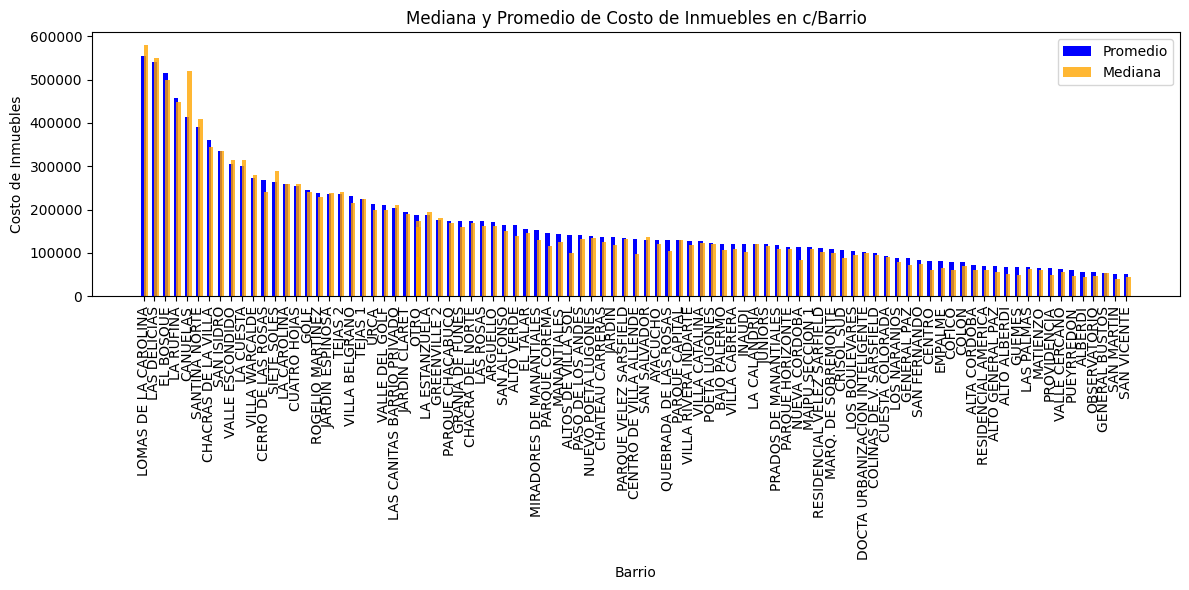

In [34]:
import matplotlib.pyplot as plt

resultados_barrio_sorted = resultados_barrio.sort_values(by='Costo Prom', ascending=False)
resultados_barrio_sorted = resultados_barrio_sorted.loc[resultados_barrio_sorted['Cant'] > 30]

plt.figure(figsize=(12, 6))
barrio_names = resultados_barrio_sorted['barrio']
print(len(barrio_names))
bar_width = 0.4

plt.bar(barrio_names, resultados_barrio_sorted['Costo Prom'], width=bar_width, label='Promedio', color='blue')

plt.bar(barrio_names, resultados_barrio_sorted['Costo Med'], width=bar_width, label='Mediana', color='orange', alpha=0.8, align='edge')

plt.xticks(rotation=90)
plt.xlabel('Barrio')
plt.ylabel('Costo de Inmuebles')
plt.title('Mediana y Promedio de Costo de Inmuebles en c/Barrio')
plt.legend()
plt.tight_layout()
plt.show()


In [35]:
resultados_barrio_sorted[['barrio', 'Costo Prom', 'Costo Med']]

,barrio,Costo Prom,Costo Med
233,LOMAS DE LA CAROLINA,554690.0,580000.0
224,LAS DELICIAS,541097.0,550000.0
126,EL BOSQUE,515704.0,500000.0
215,LA RUFINA,456757.0,447500.0
72,CANUELAS,414394.0,520000.0
...,...,...,...
6,ALBERDI,56338.0,45000.0
291,OBSERVATORIO,55326.0,47500.0
151,GENERAL BUSTOS,53168.0,53000.0
382,SAN MARTIN,52086.0,40000.0


In [36]:
import pandas as pd

# Step 2: Calculate the price per squared meter ($/m²) for each group
inmuebles_filt['precio_m2_total'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoTotal']
inmuebles_filt['precio_m2_edif'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoEdificado']

# Step 1: Group the data by 'ciudad', 'barrio', and 'tipoPropiedad'
grouped_data = inmuebles_filt.groupby(['ciudad', 'barrio', 'tipoPropiedad'])

# Step 3: Calculate the mean price per squared meter for each group
precio_m2_total_mean = grouped_data['precio_m2_total'].mean().round(0)
precio_m2_total_median = grouped_data['precio_m2_total'].median().round(0)
precio_m2_edif_mean = grouped_data['precio_m2_edif'].mean().round(0)
precio_m2_edif_median = grouped_data['precio_m2_edif'].median().round(0)

# Step 4: Calculate the count of properties in each group
group_counts = grouped_data.size()

# Reset index to convert the grouped results to DataFrames
precio_m2_total_mean_df = precio_m2_total_mean.reset_index()
precio_m2_edif_mean_df = precio_m2_edif_mean.reset_index()
precio_m2_total_median_df = precio_m2_total_median.reset_index()
precio_m2_edif_median_df = precio_m2_edif_median.reset_index()

# Rename columns for clarity
precio_m2_total_mean_df.rename(columns={'precio_m2_total': 'Precio m2 Total Mean'}, inplace=True)
precio_m2_edif_mean_df.rename(columns={'precio_m2_edif': 'Precio m2 Edif Mean'}, inplace=True)
precio_m2_total_median_df.rename(columns={'precio_m2_total': 'Precio m2 Total Median'}, inplace=True)
precio_m2_edif_median_df.rename(columns={'precio_m2_edif': 'Precio m2 Edif Median'}, inplace=True)

# Step 5: Add the count column to each DataFrame
precio_m2_edif_median_df['Count'] = group_counts.values

# Step 6: Merge the results into a single DataFrame
merged_df = pd.merge(precio_m2_total_mean_df, precio_m2_edif_mean_df, on=['ciudad', 'barrio', 'tipoPropiedad'])
merged_df = pd.merge(merged_df, precio_m2_total_median_df, on=['ciudad', 'barrio', 'tipoPropiedad'])
merged_df = pd.merge(merged_df, precio_m2_edif_median_df, on=['ciudad', 'barrio', 'tipoPropiedad'])


merged_df["Total Delta"] = abs(merged_df["Precio m2 Total Mean"] - merged_df['Precio m2 Total Median'])
merged_df["Edif Delta"] = abs(merged_df["Precio m2 Edif Mean"] - merged_df['Precio m2 Edif Median'])


19


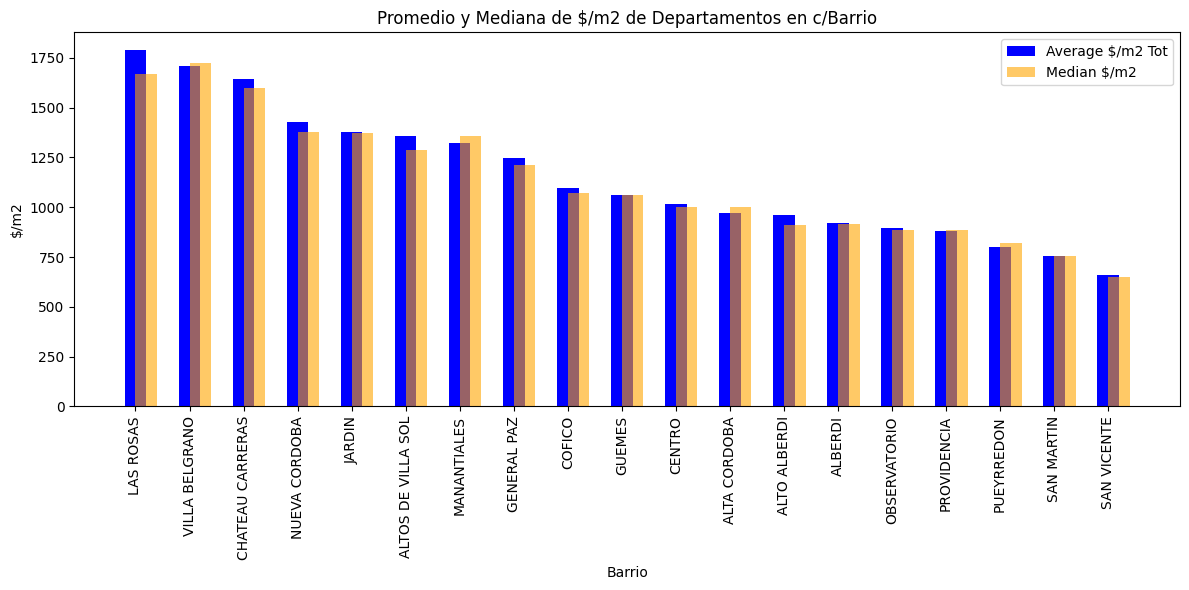

In [37]:
import matplotlib.pyplot as plt

# Filter the DataFrame to include only rows with 'tipoPropiedad' equal to 'DEPARTAMENTO'
departamento_df = merged_df.sort_values("Precio m2 Total Mean", ascending=False)
departamento_df = departamento_df[(departamento_df['tipoPropiedad'] == 'DEPARTAMENTO') & (departamento_df["Count"] > 30)]
plt.figure(figsize=(12, 6))
barrio_names = departamento_df['barrio']
print(len(barrio_names))
bar_width = 0.4

# Plot the bar for average house cost
plt.bar(barrio_names, departamento_df['Precio m2 Total Mean'], width=bar_width, label='Average $/m2 Tot', color='blue')

# Plot the bar for median house cost (shifted horizontally by bar_width)
plt.bar(barrio_names, departamento_df['Precio m2 Total Median'], width=bar_width, label='Median $/m2', color='orange', alpha=0.6, align='edge')

plt.xticks(rotation=90)
plt.xlabel('Barrio')
plt.ylabel('$/m2')
plt.title('Promedio y Mediana de $/m2 de Departamentos en c/Barrio')
plt.legend()
plt.tight_layout()
plt.show()


In [38]:
departamento_df[['barrio', 'Precio m2 Total Mean', 'Precio m2 Total Median']]

,barrio,Precio m2 Total Mean,Precio m2 Total Median
268,LAS ROSAS,1789.0,1667.0
545,VILLA BELGRANO,1708.0,1722.0
121,CHATEAU CARRERAS,1644.0,1597.0
332,NUEVA CORDOBA,1430.0,1378.0
210,JARDIN,1380.0,1372.0
39,ALTOS DE VILLA SOL,1360.0,1289.0
310,MANANTIALES,1324.0,1359.0
185,GENERAL PAZ,1246.0,1212.0
126,COFICO,1095.0,1071.0
195,GUEMES,1059.0,1062.0


76


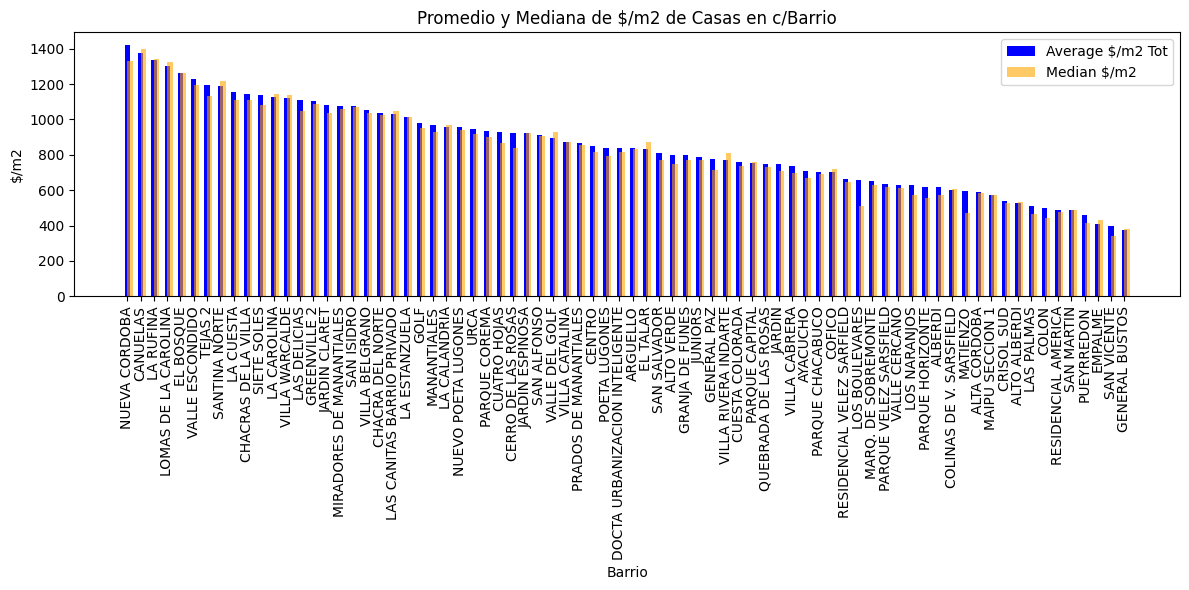

In [39]:
import matplotlib.pyplot as plt

# Filter the DataFrame to include only rows with 'tipoPropiedad' equal to 'DEPARTAMENTO'
filt = (merged_df['tipoPropiedad'] == 'CASA') & (merged_df["Count"] > 30) & (merged_df['barrio'] != 'OTRO')
casa_df = merged_df.loc[filt].sort_values("Precio m2 Edif Mean", ascending=False)
plt.figure(figsize=(12, 6))
barrio_names = casa_df['barrio']
print(len(barrio_names))
bar_width = 0.4

# Plot the bar for average house cost
plt.bar(barrio_names, casa_df['Precio m2 Edif Mean'], width=bar_width, label='Average $/m2 Edif', color='blue')

# Plot the bar for median house cost (shifted horizontally by bar_width)
plt.bar(barrio_names, casa_df['Precio m2 Edif Median'], width=bar_width, label='Median $/m2 Edif', color='orange', alpha=0.6, align='edge')

plt.xticks(rotation=90)
plt.xlabel('Barrio')
plt.ylabel('$/m2')
plt.title('Promedio y Mediana de $/m2 de Casas en c/Barrio')
plt.legend()
plt.tight_layout()
plt.show()


In [40]:
casa_df['prom'] = (casa_df['Precio m2 Edif Mean'] + casa_df['Precio m2 Edif Median'])/2
rank = casa_df[['barrio', 'prom']].head(30).reset_index()
rank

,index,barrio,prom
0,331,NUEVA CORDOBA,1377.5
1,94,CANUELAS,1388.0
2,610,LA RUFINA,1339.0
3,271,LOMAS DE LA CAROLINA,1316.5
4,158,EL BOSQUE,1264.0
5,529,VALLE ESCONDIDO,1212.0
6,508,TEJAS 2,1164.0
7,484,SANTINA NORTE,1203.0
8,605,LA CUESTA,1133.5
9,638,CHACRAS DE LA VILLA,1127.5


In [50]:
filt = inmuebles_filt["coordX"].notna() & (inmuebles_filt['tipoPropiedad'] == 'DEPARTAMENTO')
ubicados = inmuebles_filt.loc[filt]

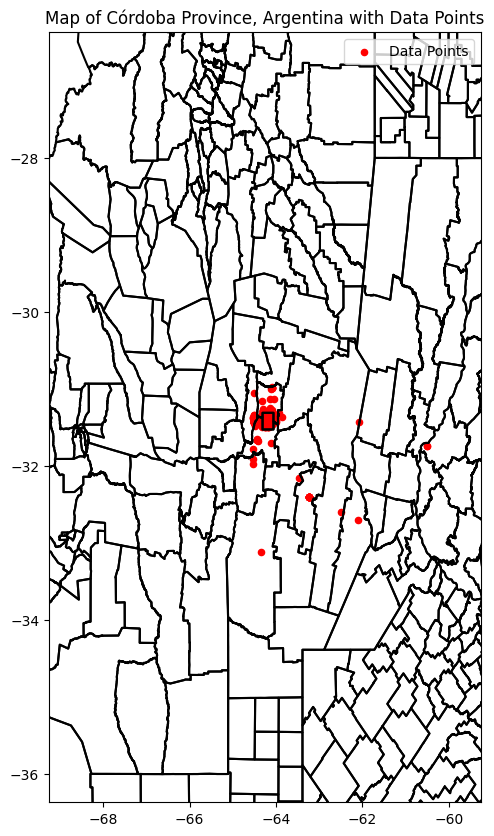

In [51]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'ubicados' and has columns 'coordX' (latitude) and 'coordY' (longitude)
# Replace these values with the actual column names from your DataFrame
latitudes = ubicados['coordX']
longitudes = ubicados['coordY']

# Calculate the mean latitude and longitude to center the map
mean_latitude = latitudes.mean()
mean_longitude = longitudes.mean()

# Read the shapefile of Córdoba province
cordoba_shapefile = './utils/maps/departamento.shp'
cordoba_province = gpd.read_file(cordoba_shapefile)

# Create a plot with the province boundary and center the map on the mean position
fig, ax = plt.subplots(figsize=(10, 10))
cordoba_province.boundary.plot(ax=ax, color='black')
ax.scatter(longitudes, latitudes, color='red', s=20, label='Data Points')

# Set the extent of the map to zoom out a bit around the mean position
map_padding = 5  # Increase the padding for more zoom-out effect
ax.set_xlim(mean_longitude - map_padding, mean_longitude + map_padding)
ax.set_ylim(mean_latitude - map_padding, mean_latitude + map_padding)

# Add a title and legend
ax.set_title('Map of Córdoba Province, Argentina with Data Points')
ax.legend()

# Show the plot
plt.show()


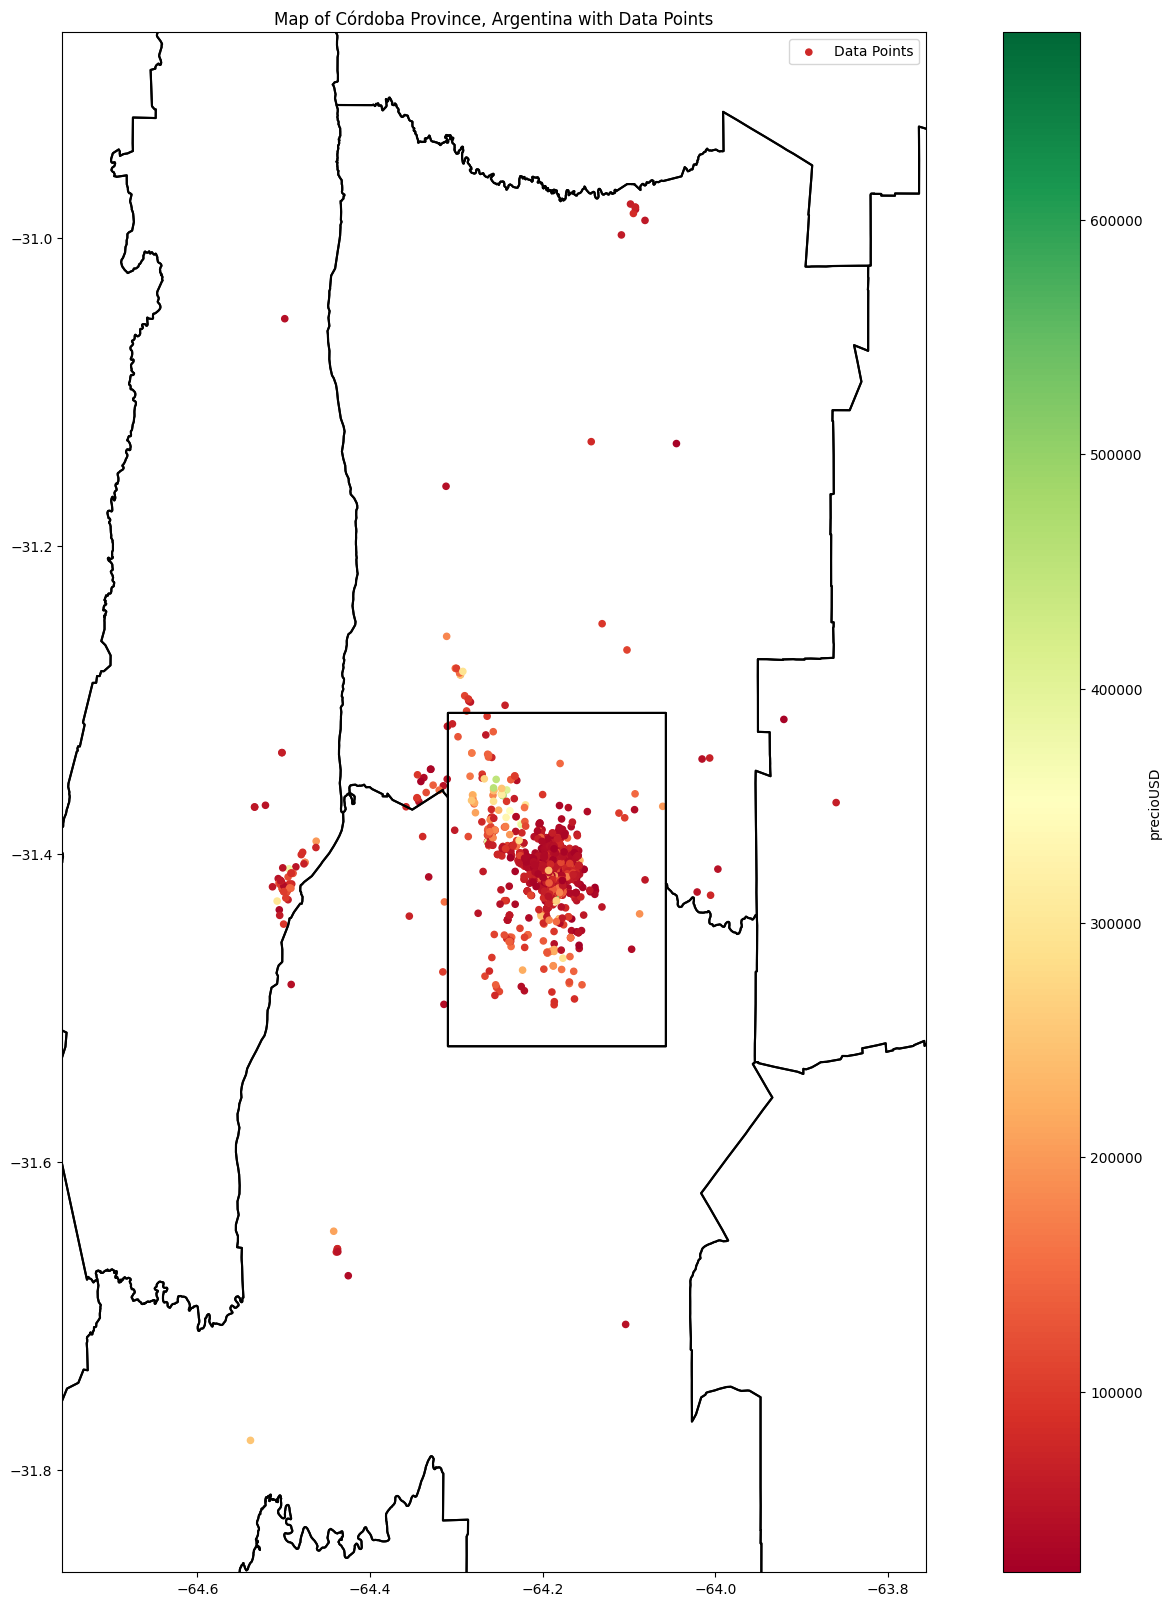

In [61]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'ubicados' and has columns 'coordX' (latitude), 'coordY' (longitude), and 'precioUSD'
# Replace these values with the actual column names from your DataFrame
latitudes = ubicados['coordX']
longitudes = ubicados['coordY']
precioUSD = ubicados['precioUSD']

# Calculate the mean latitude and longitude to center the map
mean_latitude = latitudes.mean()
mean_longitude = longitudes.mean()

# Read the shapefile of Córdoba province
cordoba_shapefile = './utils/maps/departamento.shp'
cordoba_province = gpd.read_file(cordoba_shapefile)

# Create a plot with the province boundary and center the map on the mean position
fig, ax = plt.subplots(figsize=(20, 20))
cordoba_province.boundary.plot(ax=ax, color='black')

# Color the data points based on 'precioUSD'
sc = ax.scatter(longitudes, latitudes, c=precioUSD, cmap='RdYlGn', s=20, label='Data Points')

# Set the colorbar for 'precioUSD' values
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('precioUSD')

# Set the extent of the map to zoom out a bit around the mean position
map_padding = 0.5  # Increase the padding for more zoom-out effect
ax.set_xlim(mean_longitude - map_padding, mean_longitude + map_padding)
ax.set_ylim(mean_latitude - map_padding, mean_latitude + map_padding)

# Add a title and legend
ax.set_title('Map of Córdoba Province, Argentina with Data Points')
ax.legend()

# Show the plot
plt.show()
